# Modeling for Churn Analysis

## Preparation

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data=pd.read_csv('merged_data.csv')

Removed 28 records by dropping outliers.

### Set Churn as 1

In [3]:
data['Member_Status'] = data['Member_Status'].replace({'Active': 0, 'Inactive': 1})

/var/folders/dw/5lrf5nls49q7nfzf83vn454h0000gn/T/ipykernel_46644/3595554731.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Member_Status'] = data['Member_Status'].replace({'Active': 0, 'Inactive': 1})


### Drop Features according to the EDA results

In [4]:
data.columns

Index(['Client_ID', 'Sale_Frequency', 'Preferred_Service_Time',
       'Favorite_Sales_Item', 'Ever_Purchased_Addons',
       'Ever_Purchased_Chair_Session', 'Ever_Purchased_Manager_Owner_Session',
       'Ever_Late_Cancel', 'Non_Member_Purchase_Rate', 'Member_Status',
       'Member_Next_Autopay_Amount', 'Member_Age', 'Schedule_Frequency',
       'Favorite_Therapist', 'Membership_Duration', 'Join_On_Year',
       'Join_On_Month'],
      dtype='object')

In [5]:
columns_to_drop = ['Schedule_Frequency', 'Ever_Purchased_Addons', 'Ever_Purchased_Chair_Session', 'Ever_Late_Cancel', 'Favorite_Therapist', 'Join_On_Year']
data = data.drop(columns_to_drop, axis=1)

1. Dropped features not different between groups.
2. Drop one feature from each correlated pair.
3. Dropped 'Favorite_Therapist' further because it aligns with the member joining time according to the metrics dataset.

In [6]:
data.shape

(2142, 11)

## Model Comparison

In [7]:
X = data.drop(['Member_Status', 'Client_ID'], axis=1)
y = data['Member_Status']

In [8]:
X.columns

Index(['Sale_Frequency', 'Preferred_Service_Time', 'Favorite_Sales_Item',
       'Ever_Purchased_Manager_Owner_Session', 'Non_Member_Purchase_Rate',
       'Member_Next_Autopay_Amount', 'Member_Age', 'Membership_Duration',
       'Join_On_Month'],
      dtype='object')

In [9]:
X.shape

(2142, 9)

### Training test set split

Use 30% test set because the dataset is relatively small.

In [10]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
X_train.shape

(1499, 9)

In [12]:
X_test.shape

(643, 9)

In [13]:
split = {"Total observations": [2142],
         "Training set observations": [1499],
         "Test set observations": [643]}
split_df = pd.DataFrame(split)
split_df

,Total observations,Training set observations,Test set observations
0,2142,1499,643


### Data Preprocessing
1. Cyclical features (CyclicalEncoder): 'Last_Sale_Month'
2. Categorical features (already 0,1, no encoding or scaling needed): 'Ever_Purchased_Manager_Owner_Session'
3. Categorical features (need one-hot encoding): 'Favorite_Sales_Item'
4. Numeric features (scaling): 'Member_Next_Autopay_Amount', 'Sale_Frequency', 'Preferred_Service_Time', 'Non_Member_Purchase_Rate', 'Member_Age', 'Membership_Duration'

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X is expected to be a DataFrame with a single column 'Last_Sale_Month'
        X_encoded = pd.DataFrame()  # Create an empty DataFrame
        X_encoded['sin_month'] = np.sin(2 * np.pi * X.iloc[:, 0] / 12)
        X_encoded['cos_month'] = np.cos(2 * np.pi * X.iloc[:, 0] / 12)
        return X_encoded

In [15]:
# Define cyclical data and ordinal data
cyclical_features = ['Join_On_Month']

# Define which columns should be scaled and which should be one-hot encoded
numeric_features = ['Member_Next_Autopay_Amount', 'Sale_Frequency', 'Preferred_Service_Time', 'Non_Member_Purchase_Rate', 'Member_Age', 'Membership_Duration']
categorical_features = ['Ever_Purchased_Manager_Owner_Session']
other_categorical_features = ['Favorite_Sales_Item']

# Create a column transformer with scaling for numeric features and one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cyclical', CyclicalEncoder(), cyclical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), other_categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Do not apply any transformation to the remaining columns (which can include binary 0/1 features)
)

In [16]:
# Models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Dictionary to hold evaluation results
results = {}

### Comparing Metrics and Find Optimal Model

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initializing the results dictionary to store metrics for each model
results = {
    'Model': [],
    'Accuracy': [],
    'Recall': [],
    'Specificity': [],
    'Precision': [],
    'F1 Score': [],
    'AUC': []
}

for name, model in models.items():
    # Create a full pipeline with our preprocessor and the specific model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Training the model
    pipeline.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = pipeline.predict(X_test)

    # Check if the model has the predict_proba method
    auc = 'N/A'
    if hasattr(model, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)

    # Calculating metrics
    acc = accuracy_score(y_test, y_pred)
    rec_class_0 = recall_score(y_test, y_pred)
    spec = specificity(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Storing the results
    results['Model'].append(name)
    results['Accuracy'].append(acc)
    results['Recall'].append(rec_class_0)
    results['Specificity'].append(spec)
    results['Precision'].append(prec)
    results['F1 Score'].append(f1)
    results['AUC'].append(auc)

# Converting results to a DataFrame for better readability
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)

results_df

,Accuracy,Recall,Specificity,Precision,F1 Score,AUC
Model,,,,,,
Logistic Regression,0.942457,0.997319,0.866667,0.911765,0.952625,0.978900
Decision Tree,0.939347,0.954424,0.918519,0.941799,0.948069,0.936471
Random Forest,0.944012,0.986595,0.885185,0.922306,0.953368,0.984068
SVM,0.939347,0.997319,0.859259,0.907317,0.950192,0.980866
KNN,0.940902,0.994638,0.866667,0.911548,0.951282,0.957889


### Test Set Metrics Distribution Plot

In [18]:
results_df_t = results_df.T
results_df_t

Model,Logistic Regression,Decision Tree,Random Forest,SVM,KNN
Accuracy,0.942457,0.939347,0.944012,0.939347,0.940902
Recall,0.997319,0.954424,0.986595,0.997319,0.994638
Specificity,0.866667,0.918519,0.885185,0.859259,0.866667
Precision,0.911765,0.941799,0.922306,0.907317,0.911548
F1 Score,0.952625,0.948069,0.953368,0.950192,0.951282
AUC,0.978900,0.936471,0.984068,0.980866,0.957889


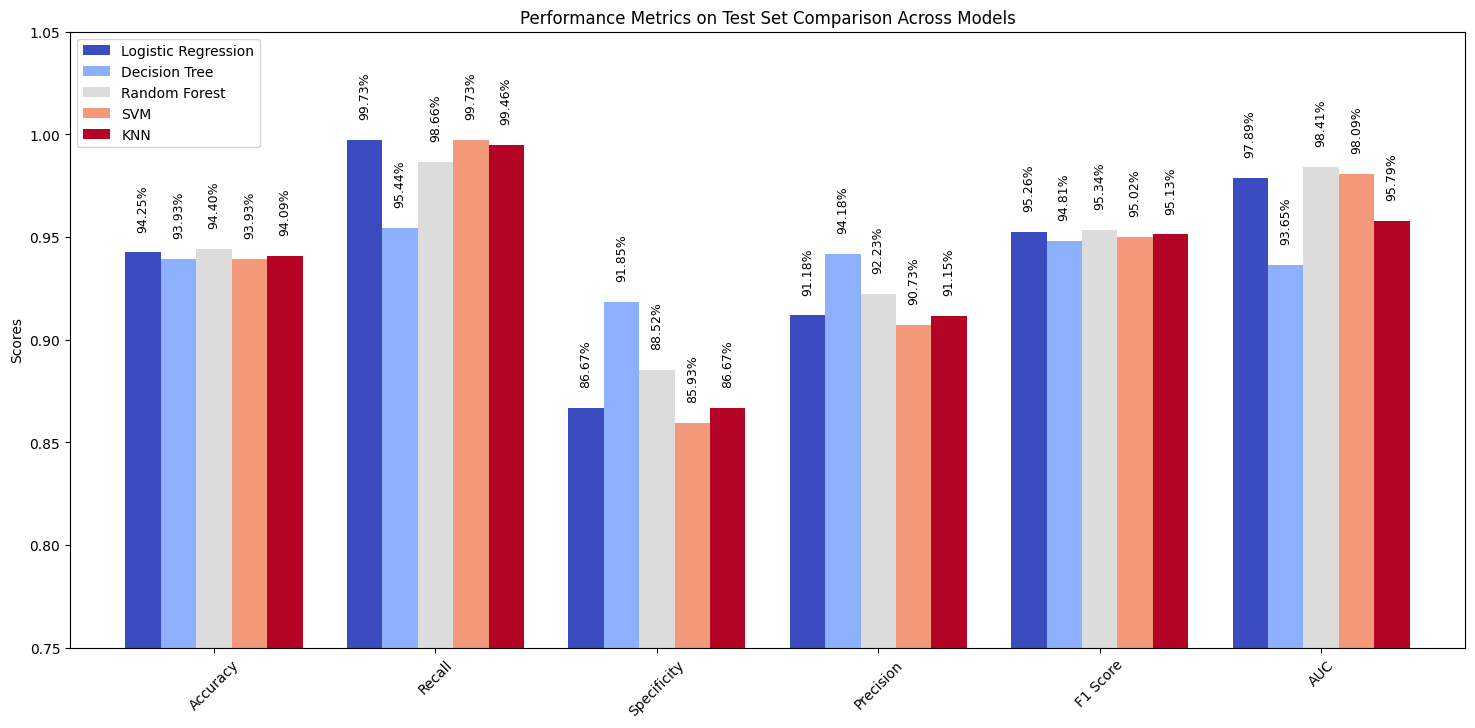

In [19]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(18, 8))  # Increased figure size

# Plotting the data
ax = results_df_t.plot(kind='bar', ax=ax, width=0.8, colormap='coolwarm')

# Setting the y-axis limits
ax.set_ylim(0.75, 1.05)  # Adjusted to give more space above the bars

# Setting labels and title
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics on Test Set Comparison Across Models')
ax.set_xticklabels(results_df_t.index, rotation=45)

# Adding percentage numbers on top of each bar
for p in ax.patches:
    # Calculating the label position
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Formatting the label
    label = f'{y:.2%}'

    # Adding the label to the plot
    ax.text(x, y + 0.01, label, ha='center', va='bottom', fontsize=9, rotation=90)  # Adjusted text properties

# Showing the legend
plt.legend(loc='upper left')

# Displaying the plot
plt.show()


Logistic Regression appears to be the optimal choice because of the high metrics and interpretability:
- It has high accuracy, comparable to Random Forest and KNN.
- It achieves the highest Recall and Specificity scores, tied with SVM, meaning it's excellent at correctly identifying inactive members and not misclassifying active ones.
- The Precision is not the highest, but it is quite close to the other models, indicating a minor trade-off.
- The F1 Score is competitive, suggesting a good balance between Precision and Recall.
- AUC is very high, indicating a strong ability to distinguish between the active and inactive classes.
- Most importantly, Logistic Regression is highly interpretable, with clear coefficients that can be translated into actionable business insights.

## Logistic Regression

### Initial model

In [25]:
# Transform the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Instantiate the Logistic Regression model
logit_model = LogisticRegression(max_iter=1000)

# Train the model
logit_model.fit(X_train_transformed, y_train)

# Predict on the training set
y_pred_logit_train = logit_model.predict(X_train_transformed)

# Generate the classification report
report_logit_train = classification_report(y_train, y_pred_logit_train)

# Predict on the test set
y_pred_logit_test = logit_model.predict(X_test_transformed)

# Generate the classification report
report_logit_test = classification_report(y_test, y_pred_logit_test)

print('The classification report for training set is:')
print(report_logit_train)

print('The classification report for test set is:')
print(report_logit_test)

The classification report for training set is:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       654
           1       0.93      0.99      0.96       845

    accuracy                           0.95      1499
   macro avg       0.96      0.95      0.95      1499
weighted avg       0.96      0.95      0.95      1499

The classification report for test set is:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       270
           1       0.91      1.00      0.95       373

    accuracy                           0.94       643
   macro avg       0.95      0.93      0.94       643
weighted avg       0.95      0.94      0.94       643



Use a regression model without regularization for better interpretability.

- The model performs very well on both the training and test sets, with high precision and recall for both classes, indicating a strong ability to correctly classify both active and inactive members. The F1-scores are also high for both classes, which suggests a good balance between precision and recall.
- The slight decrease in precision for inactive members and recall for active members from the training set to the test set indicates that the model may not generalize quite as well to new data, but the difference is small, and the overall test performance is still quite high.
- The perfect recall for inactive members in the test set indicates that the model identifies all inactive members correctly, which is particularly good if the business objective is to retain customers and prevent churn. However, the slight decrease in recall for active members in the test set (down to 87%) means that the model has missed 13% of the actual active members, classifying them as inactive.
- Overall, the model seems robust and reliable, with a small room for improvement, particularly in generalizing the recall for active members in the test set.

In [26]:
from sklearn.metrics import confusion_matrix
cm_logit_train = confusion_matrix(y_train, y_pred_logit_train)
print('The confusion matrix of training set is:')
print(cm_logit_train)

cm_logit_test = confusion_matrix(y_test, y_pred_logit_test)
print('The confusion matrix of test set is:')
print(cm_logit_test)

The confusion matrix of training set is:
[[591  63]
 [  7 838]]
The confusion matrix of test set is:
[[234  36]
 [  1 372]]


In training set, the model incorrectly predicted the positive class (active members) 7 times when they were actually inactive. In test set, the number is 1.

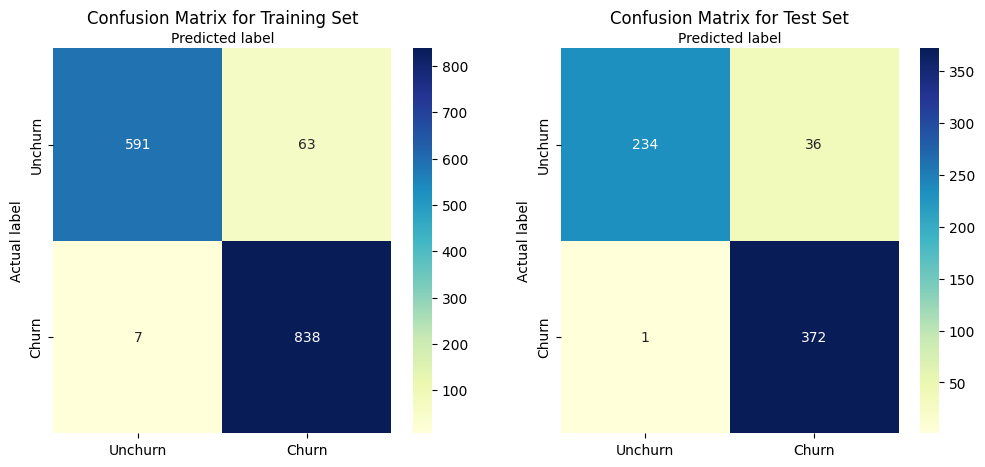

In [27]:
import seaborn as sns

class_names=['Unchurn','Churn']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for training set confusion matrix
sns.heatmap(pd.DataFrame(cm_logit_train), annot=True, cmap="YlGnBu", fmt='g', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Confusion Matrix for Training Set')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('Actual label')
axes[0].xaxis.set_label_position("top")

# Plot for test set confusion matrix
sns.heatmap(pd.DataFrame(cm_logit_test), annot=True, cmap="YlGnBu", fmt='g', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('Confusion Matrix for Test Set')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('Actual label')
axes[1].xaxis.set_label_position("top")

plt.show()

Only 1 inactive members are predicted as active (miss captured). 372 Inactive members are predicted corectly, suggesting a great model for predicting member churn.

## Result Interpretation

In [28]:
# Get the names of the features after transformation
def get_transformed_feature_names(column_transformer):
    # Initialize an empty list to hold the names of the transformed features
    transformed_feature_names = []

    # Loop through each transformer in the column transformer
    for transformer_name, transformer, columns in column_transformer.transformers_:
        if transformer_name == 'cyclical':  # Cyclical features
            # Assuming there's only one cyclical feature as per your CyclicalEncoder implementation
            transformed_feature_names.extend(['sin_month', 'cos_month'])
        elif transformer_name == 'cat':  # Categorical features
            # Get feature names from one-hot encoder
            feature_names = transformer.get_feature_names_out(columns)
            transformed_feature_names.extend(feature_names)
        elif transformer_name == 'num':  # Numeric features
            transformed_feature_names.extend(columns)  # Column names remain the same

    # Handle remaining columns that were passed through without any transformation
    if column_transformer.remainder == 'passthrough':
        # Assuming 'remainder' columns are at the end. Adjust if your setup is different.
        remainder_cols = [col for col in X_train.columns if col not in cyclical_features + categorical_features + numeric_features]
        transformed_feature_names.extend(remainder_cols)

    return transformed_feature_names

# Get the transformed feature names
transformed_feature_names = get_transformed_feature_names(preprocessor)

# Print the transformed feature names to verify
len(transformed_feature_names)

23

In [29]:
transformed_feature_names

['sin_month',
 'cos_month',
 'Favorite_Sales_Item_AROMARITUAL (SEASONAL)',
 'Favorite_Sales_Item_AROMARITUAL CALM',
 'Favorite_Sales_Item_COUPLES MASSAGE SESSION',
 'Favorite_Sales_Item_CUPPING MASSAGE SESSION',
 'Favorite_Sales_Item_ELITE LEVEL',
 'Favorite_Sales_Item_HERBAL RITUAL',
 'Favorite_Sales_Item_HIMALAYAN SALT STONE MASSAGE SESSION',
 'Favorite_Sales_Item_LATE CANCEL FEE',
 'Favorite_Sales_Item_MANAGER/OWNER MASSAGE SESSION',
 'Favorite_Sales_Item_MASSAGE SESSION',
 'Favorite_Sales_Item_MONTHLY MASSAGE SESSION',
 'Favorite_Sales_Item_NEW MEMBER SIGNUP',
 'Favorite_Sales_Item_PRENATAL MASSAGE SESSION',
 'Favorite_Sales_Item_WELLNESS PROGRAM',
 'Member_Next_Autopay_Amount',
 'Sale_Frequency',
 'Preferred_Service_Time',
 'Non_Member_Purchase_Rate',
 'Member_Age',
 'Membership_Duration',
 'Favorite_Sales_Item']

In [30]:
# Get the logistic regression coefficients
logit_coefficients = logit_model.coef_[0]

# Create a dictionary to store feature importance and odds ratios
logistic_regression_coeff_odds_ratio = {}

# Loop through transformed feature names and coefficients
for feature_name, coefficient in zip(transformed_feature_names, logit_coefficients):
    odds_ratio = np.exp(coefficient)  # Calculate odds ratio
    logistic_regression_coeff_odds_ratio[feature_name] = {'Absolute_coefficient': abs(coefficient), 'Coefficient': coefficient, 'Odds_ratio': odds_ratio}

# Sort feature importance dictionary by the absolute coefficient values within each sub-dictionary
logistic_regression_coeff_sorted = dict(sorted(logistic_regression_coeff_odds_ratio.items(), key=lambda item: item[1]['Absolute_coefficient'], reverse=True))

# Print top 4 feature importance and odds ratios
print('Top 4 important features and their odds ratios:')
count = 0
for feature, metrics in logistic_regression_coeff_sorted.items():
    if count >= 4:
        break
    print(f"{feature}: Absolute_coefficient={metrics['Absolute_coefficient']:.2f}, Coefficient={metrics['Coefficient']:.2f}, Odds_ratio={metrics['Odds_ratio']:.2f}")
    count += 1

Top 4 important features and their odds ratios:
Member_Next_Autopay_Amount: Absolute_coefficient=3.44, Coefficient=-3.44, Odds_ratio=0.03
Sale_Frequency: Absolute_coefficient=1.73, Coefficient=-1.73, Odds_ratio=0.18
Membership_Duration: Absolute_coefficient=1.59, Coefficient=1.59, Odds_ratio=4.90
Favorite_Sales_Item_HIMALAYAN SALT STONE MASSAGE SESSION: Absolute_coefficient=0.84, Coefficient=-0.84, Odds_ratio=0.43


In [31]:
logistic_regression_coeff_sorted

{'Member_Next_Autopay_Amount': {'Absolute_coefficient': 3.441697285303352,
  'Coefficient': -3.441697285303352,
  'Odds_ratio': 0.03201030856818864},
 'Sale_Frequency': {'Absolute_coefficient': 1.7273975409000526,
  'Coefficient': -1.7273975409000526,
  'Odds_ratio': 0.17774638627235975},
 'Membership_Duration': {'Absolute_coefficient': 1.588537556238125,
  'Coefficient': 1.588537556238125,
  'Odds_ratio': 4.896582712667507},
 'Favorite_Sales_Item_HIMALAYAN SALT STONE MASSAGE SESSION': {'Absolute_coefficient': 0.8360547331175515,
  'Coefficient': -0.8360547331175515,
  'Odds_ratio': 0.43341710089816327},
 'cos_month': {'Absolute_coefficient': 0.38963283793368575,
  'Coefficient': -0.38963283793368575,
  'Odds_ratio': 0.6773055097411393},
 'Favorite_Sales_Item': {'Absolute_coefficient': 0.36509471357356094,
  'Coefficient': 0.36509471357356094,
  'Odds_ratio': 1.4406504508400788},
 'Favorite_Sales_Item_ELITE LEVEL': {'Absolute_coefficient': 0.3184879006707883,
  'Coefficient': -0.318487

In [32]:
# Convert to DataFrame
df_logistic_regression_coeff_sorted = pd.DataFrame.from_dict(logistic_regression_coeff_sorted, orient='index').reset_index()
# Reset index to turn the index into a column
df_logistic_regression_coeff_sorted.rename(columns={'index': 'Feature'}, inplace=True)

df_logistic_regression_coeff_sorted

,Feature,Absolute_coefficient,Coefficient,Odds_ratio
0,Member_Next_Autopay_Amount,3.441697,-3.441697,0.032010
1,Sale_Frequency,1.727398,-1.727398,0.177746
2,Membership_Duration,1.588538,1.588538,4.896583
3,Favorite_Sales_Item_HIMALAYAN SALT STONE MASSA...,0.836055,-0.836055,0.433417
4,cos_month,0.389633,-0.389633,0.677306
5,Favorite_Sales_Item,0.365095,0.365095,1.440650
6,Favorite_Sales_Item_ELITE LEVEL,0.318488,-0.318488,0.727248
7,Favorite_Sales_Item_MONTHLY MASSAGE SESSION,0.261124,-0.261124,0.770185
8,Favorite_Sales_Item_HERBAL RITUAL,0.200926,0.200926,1.222535
9,Favorite_Sales_Item_LATE CANCEL FEE,0.197722,0.197722,1.218623


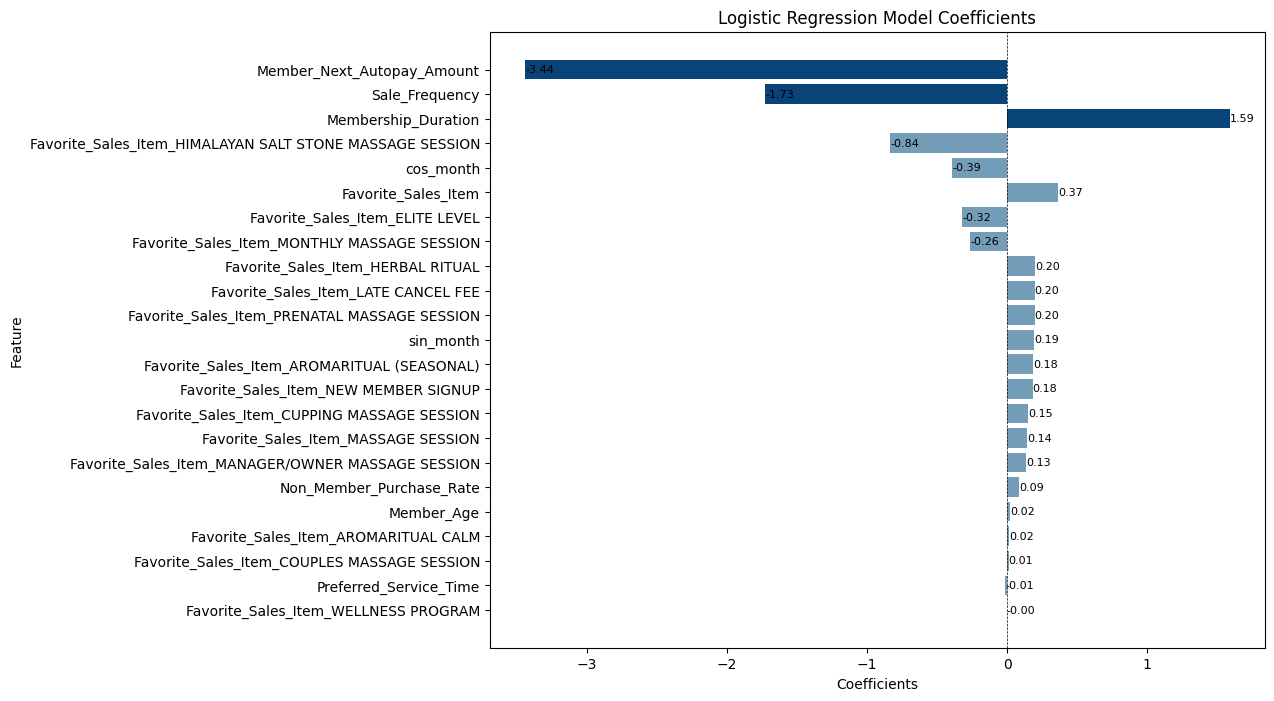

In [33]:
# Plotting coefficients with the sorted values
colors = ['#749eb8' if i > 2 else '#084478' for i in range(len(df_logistic_regression_coeff_sorted))]

plt.figure(figsize=(10, 8))
plt.barh(df_logistic_regression_coeff_sorted['Feature'], df_logistic_regression_coeff_sorted['Coefficient'], color=colors)

for index, value in enumerate(df_logistic_regression_coeff_sorted['Coefficient']):
    plt.text(
        value,  # x-position
        index,  # y-position
        f"{value:.2f}",  # text
        va='center',  # vertical alignment
        ha='left',  # horizontal alignment
        fontsize=8  # smaller font size to fit the annotations
    )

plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 0.5)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.title('Logistic Regression Model Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.show()

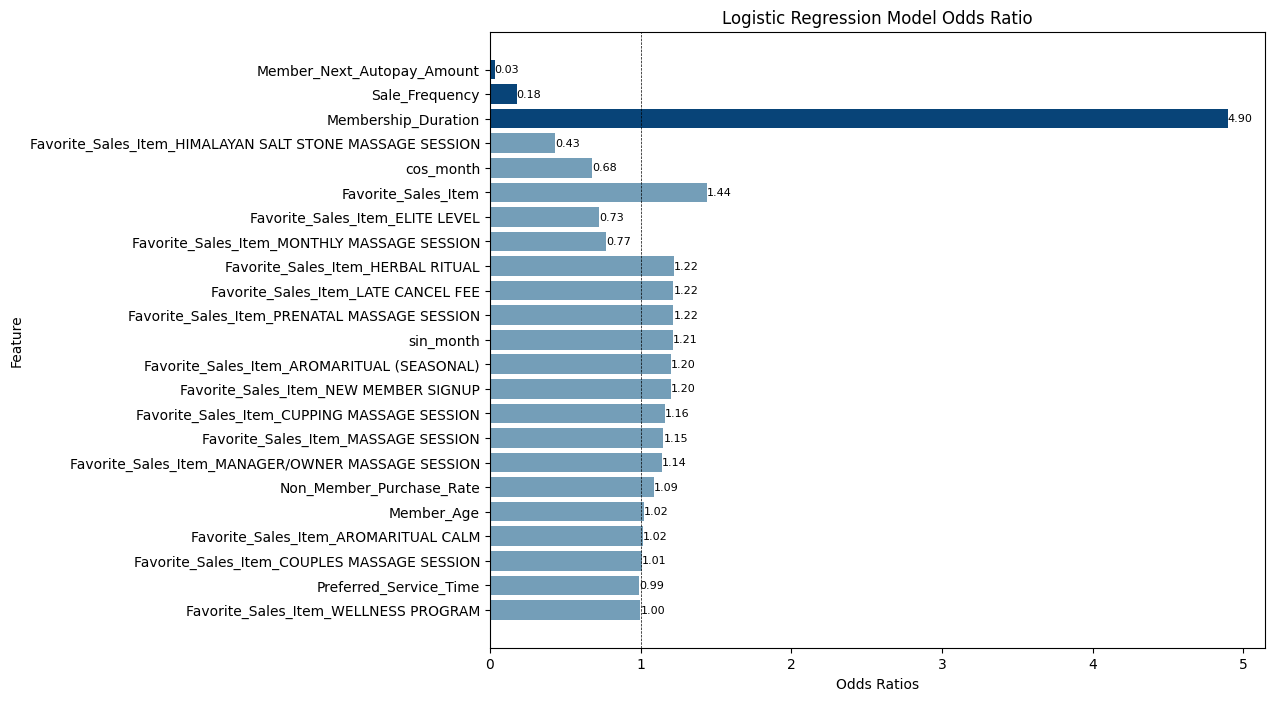

In [34]:
# Plotting odds ratio with the sorted values
colors = ['#749eb8' if i > 2 else '#084478' for i in range(len(df_logistic_regression_coeff_sorted))]

plt.figure(figsize=(10, 8))
plt.barh(df_logistic_regression_coeff_sorted['Feature'], df_logistic_regression_coeff_sorted['Odds_ratio'], color=colors)

for index, value in enumerate(df_logistic_regression_coeff_sorted['Odds_ratio']):
    plt.text(
        value,  # x-position
        index,  # y-position
        f"{value:.2f}",  # text
        va='center',  # vertical alignment
        ha='left',  # horizontal alignment
        fontsize=8  # smaller font size to fit the annotations
    )

plt.axvline(x = 1, color = 'k', linestyle = '--', linewidth = 0.5)
plt.xlabel('Odds Ratios')
plt.ylabel('Feature')
plt.title('Logistic Regression Model Odds Ratio')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.show()

1. Customers who's most frequent purchased item is PRENATAL MASSAGE SESSION have 931 times the odds of churning compared to those who do not. This could be tied to specific circumstances in a customer's life. It’s possible that after the customer has given birth, the need or desire for that specific service diminishes, naturally increasing churn. 
2. Customers who's most frequent purchased item is LATE CANCEL FEE have 905 times the odds of churning compared to those who do not. It might be worth reviewing the cancellation policy. Perhaps customers find it too strict or punitive, suggesting a need for more flexible terms.
3. Customers who's most frequent purchased item is MANAGER/OWNER MASSAGE SESSION have 516 times the odds of churning compared to those who do not. This is a rare item compared to others, the results could be impacted by rare events bias.